In [1]:
import sys
sys.path.insert(0, "/home/ubuntu/data/code/Modules/")
import skimage
import numpy as np
import pickle
import gc
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.metrics import confusion_matrix
import cv2
import matplotlib.pyplot as plt
from keras import backend
from keras.models import Sequential
from keras.losses import binary_crossentropy
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, BatchNormalization, Flatten, Dropout
from keras.optimizers import SGD,Adadelta
import DataGenerator
from albumentations import Compose,HorizontalFlip, VerticalFlip, ToFloat
from sklearn.model_selection import KFold
import random
import glob
import CNN_Module as cnn_module
import models
import time

Using TensorFlow backend.


In [2]:
import imp
imp.reload(cnn_module)
imp.reload(models)

<module 'models' from '/home/ubuntu/data/code/Modules/models.py'>

In [3]:
model = models.get_luke_model_140(input_shape=(140,100,1))
#model = models.get_luke_model_noBN(140,100)
augment_train, augment_valid = cnn_module.get_augmentations_train_test()
params_train, params_test = cnn_module.get_params_train_test(140,100,augment_valid,augment_valid)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
sample_gap=10
epochs=30
stepsperepoch=100
k = 5
video_path = '/cropped_video100_140'


start = time.time()    

#prep cells for feeding into CNN
cipro_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/resistant/'))
print(len(cipro_con_cells))
trim_con_cells = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/resistant/'))
print(len(trim_con_cells))
cipro_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/susceptible/'))
print(len(cipro_sus_cells))
trim_sus_cells     = np.array(cnn_module.findallcells_indir('/home/ubuntu/data/trimdata/susceptible/'))
print(len(trim_sus_cells))

control_cells = np.append(cipro_con_cells, trim_con_cells)
sus_cells = np.append(cipro_sus_cells, trim_sus_cells)

#label cells, and split cells into test and train, making sure to have equal proportion of sus and ctrl in both
control_cells_label = cnn_module.create_label_dict(control_cells,0)
sus_cells_label     = cnn_module.create_label_dict(sus_cells,1)
print(len(sus_cells_label))
train_ctrl, test_ctrl = cnn_module.split_train_test(control_cells_label,0.8)
train_sus, test_sus = cnn_module.split_train_test(sus_cells_label,0.8)

train_labels = train_ctrl+train_sus
test_labels = test_ctrl+test_sus
all_labels = train_labels+test_labels
random.shuffle(all_labels)

#im_paths_train, im_labels_train, im_paths_test, im_labels_test = cnn_module.get_labels_images(train_labels,test_labels,video_path,sample_gap)
#random.shuffle(im_paths_train)
#random.shuffle(im_paths_test)
# now all cells are labeled, add together to send to kfold as we don't need to reserve a train set


validate_steps = len(im_paths_test)//32
model = models.get_luke_model_140(input_shape=(140,100,1))
#model = models.get_luke_model_noBN(140,100)

#get kfold predictions from training set 
train_preds, kfold_val_acc, kfold_acc, kfold_val_loss = cnn_module.k_fold_train_split(all_labels,video_path,model,sample_gap,epochs,stepsperepoch,params_train,params_test,k)


end = time.time()
run_time = end-start
print('time =', run_time)    

318
253
362
257
619
fold 1
Epoch 1/30
100/100 [==============================] - 8s 82ms/step - loss: 2.4097 - acc: 0.5469 - val_loss: 0.6633 - val_acc: 0.7104
Epoch 2/30
100/100 [==============================] - 6s 65ms/step - loss: 0.7733 - acc: 0.5900 - val_loss: 0.6621 - val_acc: 0.7254
Epoch 3/30
100/100 [==============================] - 6s 64ms/step - loss: 0.7224 - acc: 0.5978 - val_loss: 0.7632 - val_acc: 0.6525
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.6765 - acc: 0.6297 - val_loss: 0.8595 - val_acc: 0.7052
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.6365 - acc: 0.6228 - val_loss: 0.7165 - val_acc: 0.5289
Epoch 6/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6218 - acc: 0.6669 - val_loss: 1.2648 - val_acc: 0.3895
Epoch 7/30
100/100 [==============================] - 7s 67ms/step - loss: 0.6128 - acc: 0.6594 - val_loss: 0.7534 - val_acc: 0.6791
Epoch 8/30
100/100 [======================

In [6]:
result = (train_preds, kfold_val_acc, kfold_acc, kfold_val_loss)

In [6]:
#pickle.dump(result, open('/home/ubuntu/data/code/2dCNN/kfold5_mix_bad.p','wb'))

In [7]:
import pickle
result_all = result
#result_all = pickle.load(open('/home/ubuntu/data/code/2dCNN/kfold5_mix_bad.p','rb'))
kfold_val_acc = result_all[1]
kfold_acc = result_all[2]
kfold_val_loss = result_all[3]
#kfold_loss = result_all[4]

In [8]:
import numpy as np
val_acc_avg = np.mean(kfold_val_acc, axis = 0)
print(val_acc_avg)

[0.63181686 0.65419194 0.698423   0.63016689 0.55863278 0.59949225
 0.57311146 0.58159723 0.55791889 0.64065253 0.60173811 0.59640711
 0.60667882 0.61834217 0.62859057 0.58645171 0.60186791 0.60813687
 0.6035925  0.59511865 0.61034949 0.58364526 0.59677557 0.63765947
 0.64776182 0.62702343 0.60533865 0.61119155 0.62404427 0.64918637]


In [9]:
import numpy as np
acc_avg = np.mean(kfold_acc, axis = 0)
print(acc_avg)

[0.57725   0.6141875 0.6426875 0.671     0.699125  0.735375  0.7635
 0.8035    0.8323125 0.8484375 0.8715625 0.88775   0.8980625 0.9143125
 0.9243125 0.9304375 0.935875  0.9424375 0.947375  0.9501875 0.9515
 0.9555625 0.958875  0.9561875 0.96125   0.95925   0.96025   0.96
 0.9620625 0.961625 ]


In [10]:
import numpy as np
val_loss_avg = np.mean(kfold_val_loss, axis = 0)
print(val_loss_avg)

[0.66599352 0.66441952 0.64332879 0.64988275 0.87146145 0.7010029
 1.11952997 1.69172947 2.17378412 2.14514383 1.71526193 1.03525409
 1.72375773 2.50107702 2.20628511 3.29172083 2.61670389 2.14726751
 2.4737053  2.62821629 2.48749978 2.90731176 2.803859   2.49560873
 1.91934896 3.43387676 2.41419338 3.63102333 2.56730707 2.60142858]


(0.5, 1)

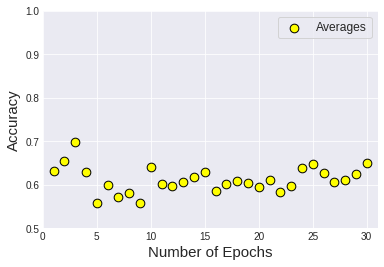

In [11]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='upper right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 31, 5))
plt.xlim(0,31)
plt.ylim(0.5,1)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

In [ ]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,val_loss_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='upper right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Val loss', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim()

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_val_acc.png', dpi=500)

In [ ]:
x_vals=np.arange(1,31)

#bests = [np.max(np.array(i)[:,1]) for i in data]
#stds = [np.std(np.array(i)[:,1]) for i in data]

plt.style.use('seaborn-darkgrid')

#plt.scatter(np.array(data)[:,0],np.array(data)[:,1],marker='x', alpha= 0.5, label='Individual runs',color='black')
plt.scatter(x_vals,acc_avg, marker='o', s= 75, label='Averages',color='yellow', edgecolors='black',linewidth=1)
#plt.errorbar(x_vals,data_av,std,elinewidth=2,color='maroon',label='std')
plt.legend(loc='lower right',frameon=True, fontsize=12)
#plt.title('Sample gap vs accuracy')
plt.xlabel('Number of Epochs', size = 15)
plt.ylabel('Accuracy', size = 15)
plt.xticks(np.arange(0, 35, 5))
plt.xlim(0,31)
plt.ylim(0.5,1.05)

#plt.savefig('/home/ubuntu/data/figs/2dk_cs_acc.png', dpi=500)

In [ ]:
prediction_generator = DataGenerator.DataGenerator(im_paths_test, im_labels_test, **params_test)  
preds = model.predict_generator(generator=prediction_generator,workers=1,steps = len(im_paths_test)//24, use_multiprocessing=False)
filenames_preds = dict(zip(prediction_generator.filenames,preds))
im_result = np.array([(im_labels_test[key],np.argmax(filenames_preds[key])) for key in filenames_preds.keys()])
confusion_matrix(im_result[:,0], im_result[:,1])

In [ ]:
print('Normalised')
confusion_matrix(im_result[:,0], im_result[:,1])/144

In [ ]:
print('Accuracy')
(94+139)/(94+139+55)

In [ ]:
test_predictions

In [ ]:
1264+176+95+745

In [ ]:
2009/2280

In [ ]:
sample_gap